# Decision trees and ensamble methods

### Import libraries and set random state

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, \
    GradientBoostingClassifier, RandomForestClassifier

random_state = 44

### Import and scale data

In [2]:
df = pd.read_csv("../features.csv", index_col=0)
df.dropna(inplace=True)
X = df.drop(columns=['malign', 'patient_name', 'file_name'])
y = df[['malign', 'file_name']]


In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

file_train = y_train["file_name"]
file_val = y_val["file_name"]
file_test = y_test["file_name"]

y_train = y_train['malign']
y_val = y_val['malign']
y_test = y_test['malign']

### Create and fit classifiers

In [5]:
from sklearn.dummy import DummyClassifier
clfs_names = ['DummyClassifierPrior', 'DummyClassifierUniform']

dummy_prior = DummyClassifier(random_state=random_state, strategy="prior")
dummy_uniform = DummyClassifier(random_state=random_state, strategy="uniform")

clfs = [dummy_prior, dummy_uniform]
for clf in clfs:
    clf = clf.fit(X_train, y_train)


### Evaluate initial performance

#### Performance on training dataset

In [6]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_train)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_train)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_train, y_pred))
    results['F1 score'].append(f1_score(y_train, y_pred))
    results['Precision'].append(precision_score(y_train, y_pred))
    results['Recall'].append(recall_score(y_train, y_pred))

results_df = pd.DataFrame(results)
print("Performance on TRAINING set")
results_df.head(len(clfs_names))

Performance on TRAINING set


c:\Users\mlech\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Name,Accuracy,F1 score,Precision,Recall
0,DummyClassifierPrior,0.719852,0.00,0.000000,0.000000
1,DummyClassifierUniform,0.495362,0.36,0.279197,0.506623


#### Performance on validation dataset

In [7]:
y_pred = clf.predict(X_val)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_val)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_val, y_pred))
    results['F1 score'].append(f1_score(y_val, y_pred))
    results['Precision'].append(precision_score(y_val, y_pred))
    results['Recall'].append(recall_score(y_val, y_pred))

results_df = pd.DataFrame(results)
print("Performance on VALIDATION set")
results_df.head(len(clfs_names))

Performance on VALIDATION set


c:\Users\mlech\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Name,Accuracy,F1 score,Precision,Recall
0,DummyClassifierPrior,0.733333,0.000000,0.000000,0.0
1,DummyClassifierUniform,0.496296,0.346154,0.264706,0.5


#### Confusion matices for validation dataset

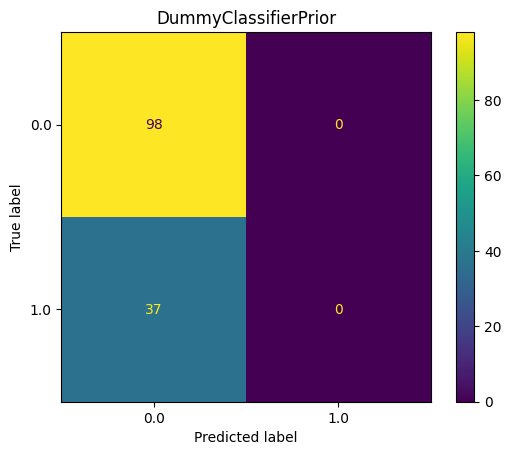

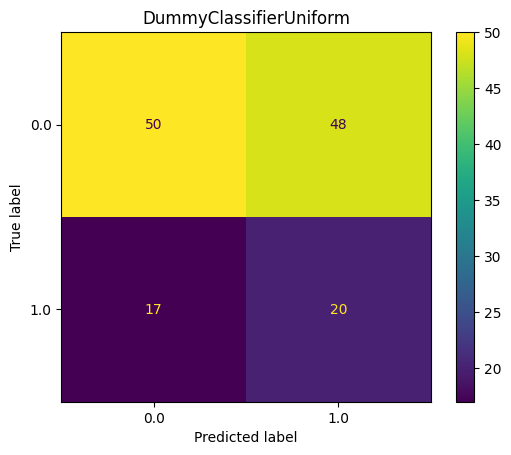

In [8]:
for clf, name in zip(clfs, clfs_names):
    y_pred = ys_pred[name]
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.title(f"{name}")
    plt.show()

### ROC analysis

#### Create ROC curve and compute AUC

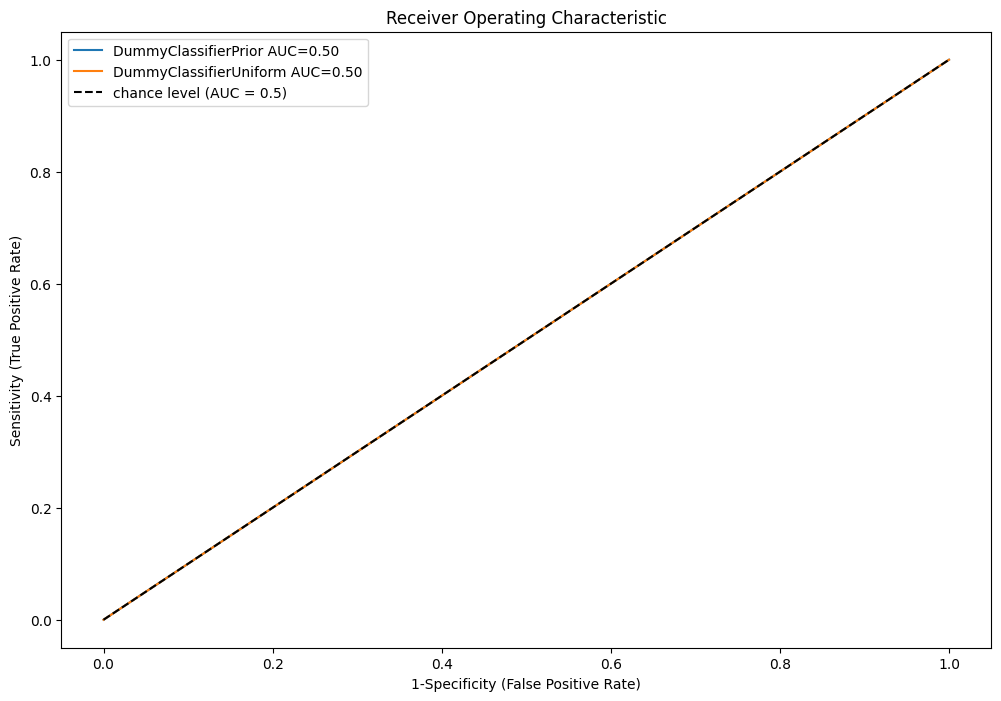

In [9]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
ys_pred_proba = {}
clfs_thresholds = {}
plt.figure(figsize=(12,8))
for clf, name in zip(clfs, clfs_names):
    y_pred_proba = clf.predict_proba(X_val)
    y_pred_proba = y_pred_proba[:, 1]
    ys_pred_proba[name] = y_pred_proba

    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    clfs_thresholds[name] = thresholds

    plt.plot(fpr,tpr,label=f"{name} AUC={roc_auc:.2f}"+str())

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel('1-Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

#### Choose best threshold

In [10]:
best_thresholds = {}
for clf, name in zip(clfs, clfs_names):
    best_f1 = 0
    best_th = 0.5
    list(clfs_thresholds[name]).append(0.5)
    for threshold in clfs_thresholds[name]:
        y_pred = ys_pred_proba[name] > threshold
        f1 = f1_score(y_val, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_th = threshold
    best_thresholds[name] = best_th
    

#### Check performance on validation dataset after threshold adjustment

In [11]:
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}

for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred = ys_pred_proba[name] > best_th
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_val, y_pred))
    results['F1 score'].append(f1_score(y_val, y_pred))
    results['Precision'].append(precision_score(y_val, y_pred))
    results['Recall'].append(recall_score(y_val, y_pred))
    results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results after threshold adjustment on VALIDATION")
results_df.head(len(clfs_names))

Results after threshold adjustment on VALIDATION


c:\Users\mlech\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mlech\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,DummyClassifierPrior,0.733333,0.0,0.0,0.0,0.5
1,DummyClassifierUniform,0.733333,0.0,0.0,0.0,0.5


### Evaluate performance on test dataset

#### Performance on test data WITHOUT threshold adjustment

In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_test)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_test)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['F1 score'].append(f1_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))

results_df = pd.DataFrame(results)
print("Results WITHOUT threshold adjustment on TEST data")
results_df.head(len(clfs_names))

Results WITHOUT threshold adjustment on TEST data


c:\Users\mlech\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Name,Accuracy,F1 score,Precision,Recall
0,DummyClassifierPrior,0.725926,0.000000,0.000000,0.000000
1,DummyClassifierUniform,0.518519,0.380952,0.294118,0.540541


#### Performance on test data WITH threshold adjustment

In [13]:
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}
ys_pred_test_proba = {}

for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    ys_pred_test_proba[name] = y_pred_proba
    y_pred = y_pred_proba > best_th
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['F1 score'].append(f1_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))
    results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results after threshold adjustment on TEST data")
results_df.head(len(clfs_names))

Results after threshold adjustment on TEST data


c:\Users\mlech\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mlech\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,DummyClassifierPrior,0.725926,0.0,0.0,0.0,0.5
1,DummyClassifierUniform,0.725926,0.0,0.0,0.0,0.5


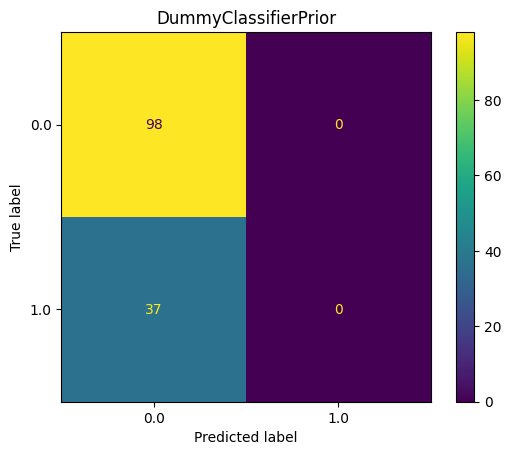

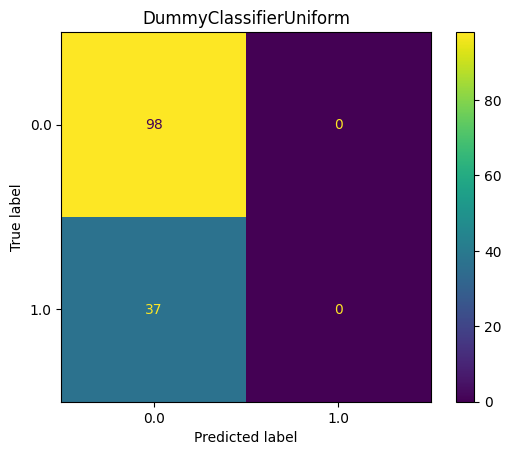

In [14]:
for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    ys_pred_test_proba[name] = y_pred_proba
    y_pred = y_pred_proba > best_th
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.title(f"{name}")
    plt.show()

IndexError: list index out of range

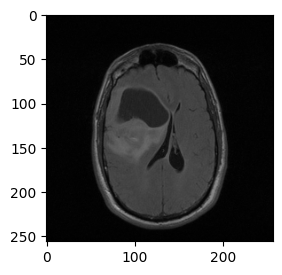

In [15]:
import cv2
import os

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img_path = os.path.join("..\data", file_test.iloc[i])
    img = cv2.imread(img_path)
    plt.imshow(img.astype("uint8"))
    plt.title(f'{clfs[4].predict(X_test[i,:].reshape(1, -1))[0] == 1}/{y_test.iloc[i]==1}')
    plt.suptitle("Predicted/Actual")
    plt.axis("off")

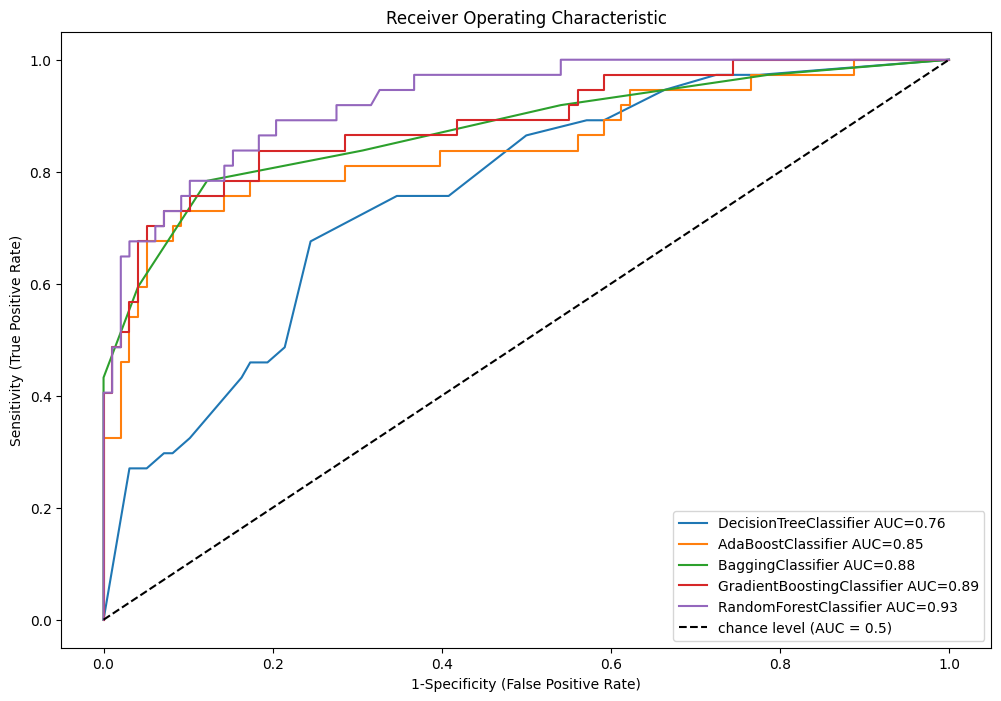

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
ys_pred_proba = {}
clfs_thresholds = {}
plt.figure(figsize=(12,8))
for clf, name in zip(clfs, clfs_names):
    y_pred_proba = clf.predict_proba(X_test)
    y_pred_proba = y_pred_proba[:, 1]
    ys_pred_proba[name] = y_pred_proba

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    clfs_thresholds[name] = thresholds

    plt.plot(fpr,tpr,label=f"{name} AUC={roc_auc:.2f}"+str())

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel('1-Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Receiver Operating Characteristic on test set')
plt.legend()
plt.show()

### Check selected features

In [ ]:

from sklearn.feature_selection import SelectFromModel


def count_classes(selected, feature_classes, original=None):
    results = []
    sum = 0
    for feature_class in feature_classes:
        counter = 0
        for elem in selected:
            if feature_class == 'square':
                if feature_class in elem and 'squareroot' not in elem:
                    counter += 1
            elif feature_class in elem:
                counter += 1
        sum += counter
        results.append([feature_class, counter])
    results.append(["sum", sum])
    results = pd.DataFrame(results, columns=["Feature class name", "Count"])

    if original is not None:
        original_count = count_classes(original, feature_classes)["Count"]
        results["Percent kept"] = results["Count"] / original_count
        results["Original Count"] = original_count

    results.head(len(feature_classes))
    return results

feature_classes = ['lbp-2D', 'gradient', 'exponential', 'logarithm', 'squareroot', 'square', 'wavelet-L', 'wavelet-H', 'original']

selector = SelectFromModel(estimator=clfs[0], prefit=True)
X = df.drop(columns=['malign', 'patient_name', 'file_name'])
selected = selector.get_feature_names_out(X.columns)

count_classes(selected, feature_classes, X.columns)

,Feature class name,Count,Percent kept,Original Count
0,lbp-2D,2,0.021978,91
1,gradient,2,0.021978,91
2,exponential,1,0.010989,91
3,logarithm,1,0.010989,91
4,squareroot,2,0.021978,91
5,square,6,0.065934,91
6,wavelet-L,4,0.043956,91
7,wavelet-H,6,0.065934,91
8,original,7,0.070000,100
9,sum,31,0.037440,828


In [ ]:
selector = SelectFromModel(estimator=clfs[1], prefit=True)
X = df.drop(columns=['malign', 'patient_name', 'file_name'])
selected = selector.get_feature_names_out(X.columns)

count_classes(selected, feature_classes, X.columns)

,Feature class name,Count,Percent kept,Original Count
0,lbp-2D,3,0.032967,91
1,gradient,6,0.065934,91
2,exponential,5,0.054945,91
3,logarithm,4,0.043956,91
4,squareroot,4,0.043956,91
5,square,7,0.076923,91
6,wavelet-L,8,0.087912,91
7,wavelet-H,7,0.076923,91
8,original,3,0.030000,100
9,sum,47,0.056763,828


In [ ]:
# selector = SelectFromModel(estimator=clfs[2], prefit=True)
# X = df.drop(columns=['malign', 'patient_name', 'file_name'])
# selected = selector.get_feature_names_out(X.columns)
# print(clfs[2].estimators_features_)
X = df.drop(columns=['malign', 'patient_name', 'file_name'])
results = pd.DataFrame(feature_classes + ["sum"], columns=["Feature class name"])
stats = np.zeros((10,3))
for est in clfs[2].estimators_:
    selector = SelectFromModel(estimator=est, prefit=True)
    selected = selector.get_feature_names_out(X.columns)
    stats += count_classes(selected, feature_classes, X.columns)[['Count',  'Percent kept',  'Original Count']]

results[['Count',  'Percent kept',  'Original Count']] = stats / len(clfs[2].estimators_)
# results = pd.DataFrame(results, columns=["Feature class name",' Count',  'Percent kept',  'Original Count'])
results.head(len(feature_classes))

,Feature class name,Count,Percent kept,Original Count
0,lbp-2D,4.6,0.050549,91.0
1,gradient,6.6,0.072527,91.0
2,exponential,4.5,0.049451,91.0
3,logarithm,6.5,0.071429,91.0
4,squareroot,6.3,0.069231,91.0
5,square,7.7,0.084615,91.0
6,wavelet-L,6.4,0.070330,91.0
7,wavelet-H,11.2,0.123077,91.0
8,original,7.7,0.077000,100.0


In [ ]:
selector = SelectFromModel(estimator=clfs[3], prefit=True)
X = df.drop(columns=['malign', 'patient_name', 'file_name'])
selected = selector.get_feature_names_out(X.columns)

count_classes(selected, feature_classes, X.columns)

,Feature class name,Count,Percent kept,Original Count
0,lbp-2D,8,0.087912,91
1,gradient,14,0.153846,91
2,exponential,11,0.120879,91
3,logarithm,17,0.186813,91
4,squareroot,19,0.208791,91
5,square,22,0.241758,91
6,wavelet-L,18,0.197802,91
7,wavelet-H,26,0.285714,91
8,original,19,0.190000,100
9,sum,154,0.185990,828
